In [242]:
using RxInfer, Plots, MAT, GraphViz, Random, Distributions, LinearAlgebra

In [243]:
file = matread("tennis_data.mat");

In [244]:
W, G = file["W"], file["G"]

println("W: ", size(W), " G: ", size(G))

W: (107, 1) G: (1801, 2)


In [245]:
samples = 1600

G = G[1:samples, :]

G =  convert(Matrix{Int}, G)

M, N = Int(maximum(G)), size(G)[1]

results = 2 * ones(samples);

In [246]:
@model function skill_model(matches, results)

    # Priors for player skills (Gaussian)
    local skills
    for i in 1:M
        skills[i] ~ Normal(μ = 0.0, σ = 2.0)
    end
    
    diff .~ skills[matches[:, 1]] - skills[matches[:, 2]]

    results .~ Normal(μ = diff, σ² = 5.0)

    #results .~ tanh(perfs)

end

In [247]:
tanh_meta = @meta begin
    tanh() -> Unscented()
end

Meta: 
  tanh() -> Unscented{Float64, Float64, Float64, Nothing}(0.001, 2.0, 0.0, nothing)


In [248]:
# model_generator = skill_model() | (matches = G, results = results)
# model_to_plot   = RxInfer.getmodel(RxInfer.create_model(model_generator))
# GraphViz.load(model_to_plot, strategy = :simple)

In [249]:
# Run inference
inference_result = infer(
    model=skill_model(matches=G, ),
    data=(results=results,),
    meta = tanh_meta,
    iterations=20,
    initialization = @initialization(μ(skills) = NormalMeanVariance(0, 2))
)

MethodError: MethodError: no method matching factornode(::ReactiveMP.UndefinedNodeFunctionalForm, ::Type{Normal}, ::Vector{Tuple{Symbol, AbstractVariable}}, ::Tuple{Vector{Int64}, Vector{Int64}, Vector{Int64}})
The function `factornode` exists, but no method is defined for this combination of argument types.`Type{Normal}` has been used but the `ReactiveMP` backend does not support `Type{Normal}` as a factor node.

Please refer to the [factor nodes](https://reactivebayes.github.io/ReactiveMP.jl/stable/lib/nodes/) section of the documentation for more details.



Closest candidates are:
  factornode(::ReactiveMP.UndefinedNodeFunctionalForm, !Matched::F, ::Any, ::Any) where F<:Function
   @ ReactiveMP C:\Users\oskar_qjw0b2g\.julia\packages\ReactiveMP\dwnsl\src\nodes\predefined\delta\delta.jl:112
  factornode(!Matched::ReactiveMP.PredefinedNodeFunctionalForm, ::F, ::I, ::Any) where {F, I}
   @ ReactiveMP C:\Users\oskar_qjw0b2g\.julia\packages\ReactiveMP\dwnsl\src\nodes\nodes.jl:190
  factornode(::F, ::I, ::Any) where {F, I}
   @ ReactiveMP C:\Users\oskar_qjw0b2g\.julia\packages\ReactiveMP\dwnsl\src\nodes\nodes.jl:184
  ...


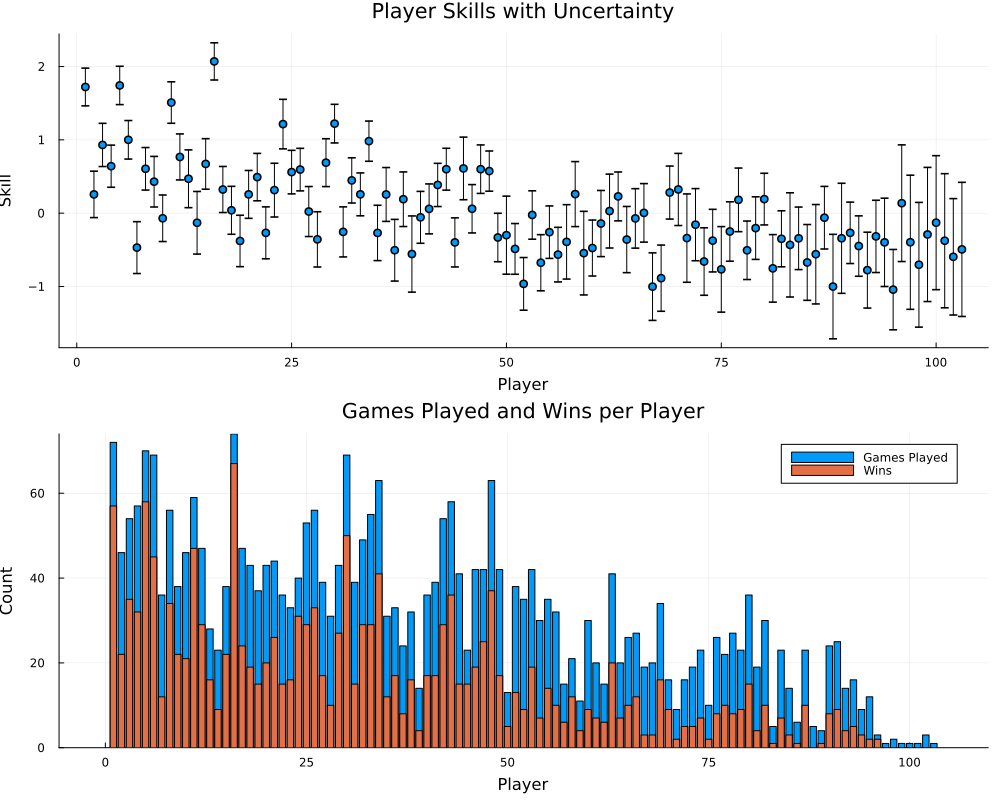

In [250]:
# Extract posterior means and variances for each player's skill
posterior_skills = inference_result.posteriors[:skills][end]
skill_means = [mean(posterior_skills[i]) for i in 1:M]
skill_stds = [std(posterior_skills[i]) for i in 1:M]

# Count number of wins for each player
win_counts = [count(==(i), G[1:samples]) for i in 1:M]

# Count number of games each player participated in
games_played = [count(x -> x == i, vcat(G[:,1], G[:,2])) for i in 1:M]

# Plot skill means with error bars (uncertainty)
p1 = scatter(1:M, skill_means, yerr=skill_stds, legend=false, xlabel="Player", ylabel="Skill", title="Player Skills with Uncertainty")

# Plot number of wins for each player
p2 = bar(1:M, [games_played win_counts], label=["Games Played" "Wins"], xlabel="Player", ylabel="Count", title="Games Played and Wins per Player", legend=:topright)

# Display plots vertically
plot(p1, p2, layout=(2,1 ), size=(1000,800))

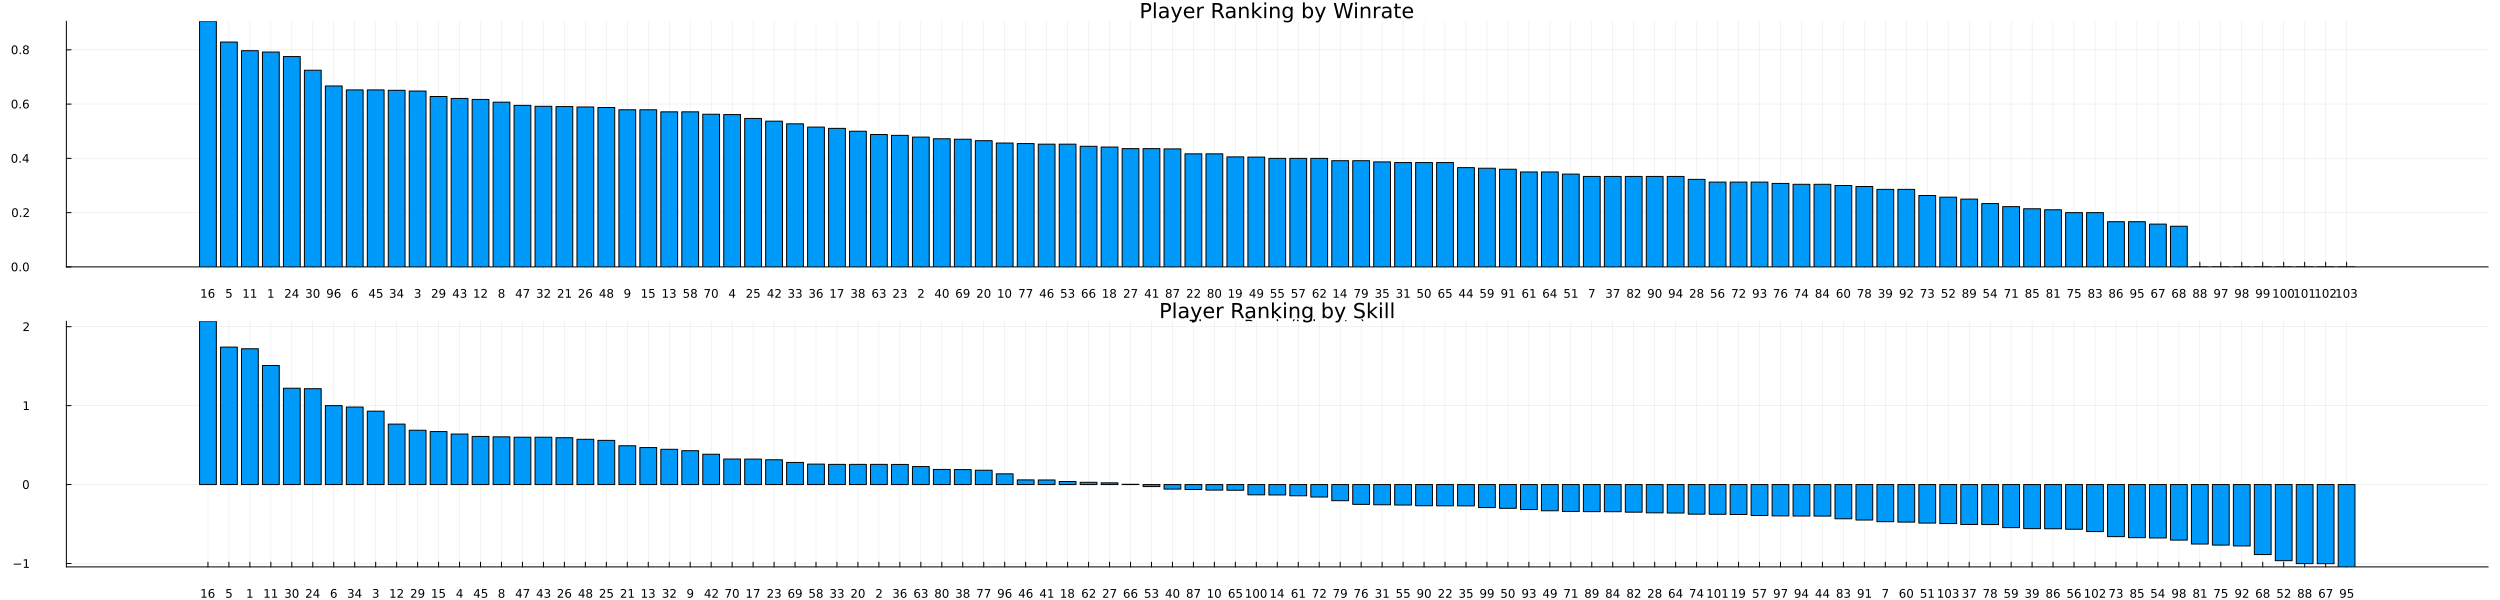

In [259]:
# Calculate winrate for each player
winrate = win_counts ./ games_played

# Get player indices sorted by winrate and skill means
rank_by_winrate = sortperm(winrate; rev=true)
rank_by_skill = sortperm(skill_means; rev=true)

# Plot ranking based on winrate
p3 = bar(1:M, winrate[rank_by_winrate], xlabel="Player Rank (Winrate)", ylabel="Winrate", 
    title="Player Ranking by Winrate", legend=false, xticks=(1:M, rank_by_winrate))

# Plot ranking based on skill
p4 = bar(1:M, skill_means[rank_by_skill], xlabel="Player Rank (Skill)", 
    ylabel="Skill", title="Player Ranking by Skill", legend=false, xticks=(1:M, rank_by_skill))

# Display both plots side by side
plot(p3, p4, layout=(2, 1), size=(2500,600))